# DSI Assessment 2 - Quantified Self

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

<b> 

Table of Contents:

* Part 1: Introduction
* Part 2: Collecting data
* Part 3: Text Pre-processing
* Part 4: Term Frequencies
* Part 5: Data Visualisation Basics
* Part 6: Sentiment Analysis Basics

</b>

Template

* Introduction
* Description of process, or method
* Analysis
* Discussion
* Conclusions
* Reflection
* References
* Appendices


## Part 1 Introduction

## Problem Statement

#### Motivation

It has been well established that the foundations of a successful project lies 
The purpose of this project is to gain insight into how we as individuals play a role in a collaborating on a data science endeavour. As communication can be seen as a critical success measure of how well project is completed, we wanted to analyse our participation in completing the DSI Assignment.

To measure our participation in the DSI assignment we collected data from chat conversations in Slack and JIRA issue tickets to get an understanding of the language used whilst collaborating and the (need to fill) . We will be using applying Natural Language processing techniques to transform and evaluate our data as well as using tools such as python and power BI to visualize and explain the insights that we have uncovered.

Text mining is being used increasingly as organizations recognize the untapped information contained in text. Social media, such as Twitter and Facebook, have been used effectively by organizations to uncover positive and negative trends that, when identified through text mining, can be used to leverage the positive trends and provide corrective action to counteract any negative comments.

## Sources of Data

#### Slack

[Slack](www.slack.com) is an instant message and team collaboration tool. Some of the features of slack is being able to create channels with different topics. For example in the case of our assignment we had channels based on the CRISP-DM framework as well as channels which were less about data science and more about free flowing discussions.

Some of the additional features of slack is the ability to incorporate customized addons. One of the addons we used was a messaging bot called Howdy. The purpose of howdy is to be an additional member of the team and allow people to reflect on what they had done as well as highlight any problems or issues occuring in the project. 

<b> Jira </b>

[Jira](https://www.atlassian.com/software/jira) is an issue tracking and projet management tool. Jira allows you to track any kind of unit of work (be it an issue, bug, story, project task, etc.) through a predefined workflow. 

Both the unit (what you call your item of work) and the workflow (the steps that item takes from open to close) can be highly customized for your team's specific requirements, whether simple or more complex.

On top of all that, JIRA's really good at tracking (via detailed, custom reports and dashboards) where all of your project items/issues lie at a teamwide, company or individual level - for example, what are all of the issues assigned to me, created in the last 7 days?

Collaboration's also a big point of emphasis in JIRA - @mentioning, formatted commenting , and sharing issues via email all help make your work more visible to your teams so folks stay on the same page throughout their project, release, or set of tasks.

Some common use cases include software development, feature implementation, bug tracking, agile project management (with JIRA Agile), and service desk ticket tracking (with JIRA Service Desk).

## Part 2 Collecting Data

One of the main issues affecting data science projects is trying to acquire the necessary amount data and also make sure that the quality of the data is in a manner which can be analysed. As the majority of our data comes from messages, we had to spend alot of time formating and transforming the text. To address these issues we applied a number of Natural Language Processing techniques.

In this section, we will go through how we extracted the data as well as a background and evaluation of the techniques used in Natural Language Processing with our final decision of techniques that we used in the assignment.

In [3]:
import pandas as pd # Data Munging tool
import os # Operating System functionality
import glob # Finds all pathnames e.g(.json)
import re # Regular Expression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer # Combines both Count Vectorizer and Tfidf Transformer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

plt.style.use('ggplot')
%matplotlib inline

C:\Users\Jared Chung\Anaconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
users = pd.read_json("C:/users/Jared Chung/Desktop/D-Matrix/users.json") #Laptop
#users = pd.read_json("C:/users/jchung/desktop/D-Matrix/users.json") #Work

In [5]:
path_to_json = 'C:/users/Jared Chung/Desktop/D-Matrix/' #Laptop
#path_to_json = 'C:/users/jchung/desktop/D-Matrix/' #Work
json_dir = os.listdir(path_to_json)
#del json_dir[0] ### do this step only if u have a mac and need to get rid of .DS Store folder
data = pd.DataFrame()
for file in json_dir:
    if "." not in file: 
        print (file)
        all_files = glob.glob(os.path.join(path_to_json + file + '/', "*.json"))
        df = pd.concat((pd.read_json(f) for f in all_files)) 
        df['channel'] = file
        df['ts'] = pd.to_datetime(df['ts'],unit='s')
        df2 = pd.DataFrame(df, columns = ['user','ts','channel','text'])
        data = data.append(df2)
    else:
        print "File contains an extenstion"

36100-dsi
36100-dsi-photos
36103-statistics
36106-dam
File contains an extenstion
crisp-businessknow
crisp-dataknow
crisp-dataprep
crisp-deploy
crisp-eval
crisp-modelling
dam
dsi
dsi-assignment-2a
general
File contains an extenstion
jira-discussion
python_instructions
random
story-telling
File contains an extenstion


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4623 entries, 0 to 17
Data columns (total 4 columns):
user       4331 non-null object
ts         4623 non-null datetime64[ns]
channel    4623 non-null object
text       4623 non-null object
dtypes: datetime64[ns](1), object(3)
memory usage: 180.6+ KB


## Part 3 Text Preprocessing

### Stemming and Lemmatizing

http://www.lnse.org/papers/134-I3007.pdf

D. A. Hull, “Stemming algorithms: A case study for detailed
evaluation,” Journal of the American Society for Information Science,
vol. 47, pp. 70-84, 1996.

One of the issues that arises in natural language processing is that words have morphligical variants which will not be recognised by term matching alogrithms (Hull 1996). This means you could have words like organize, organizes, and organizing all have the same meaning but won't be grouped together. 

Some of the techniques used to tackle this problem include Stemming and Lemmatizing


<b> Copy from Duhita Document Need to Paraphrase </b>

Stemming and Lemmatization
In linguistics and information retrieval systems, the process of reducing inflectional and derivational forms of words to a common base is called stemming and lemmatization.
Stemming is a process that chops off the ends of the words in the hope of achieving this goal correctly most of the time, and often includes the removal of derivational affixes. Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma. (Manning et al. 2008). 

There are generally 2 types of errors that can error while performing stemming operations. Under Stemming could occur when the 2 words with the same interpretation are not stemmed to the same root. Over Stemming could occur when the 2 words with different interpretation are stemmed to the same root.(Jivani & others 2011).
Types of Stemming Algorithm are
•	Truncating: It is a simple stripping technique which removes the affixes after the nth symbol. Different algorithms in this class are Lovins, Porters, Paice, Dawson
•	Statistical: Methods which removes affixes after statistical procedures examples being N-Gram, HMM, YASSM
•	Mixed: approach to stemming and it involves both the inflectional as well as the derivational morphology consideration. Some of the mixed algorithms are Inflectional and Derivational, Corpus Based, Context Sensitive
As shown in the study “A Survey on various Stemming Algorithms” (Singh & Pateriya n.d.) that none of the above mentioned stemmers give 100% productivity but are satisfactory useful to the text mining, Natural Language Processing(NLP) or Information Retrieval(IR) applications. 
The New Porter stemmer performs much better than the original stemmer and other English stemmers(Karaa 2013) and hence we decided to choose Porter’s stemmer algorithm for our project. The first one as in Porter stemmer handles inflectional morphology (plural, verb conjugation, etc.). The second step treats derivational morphology; it maps complex suffixes (suffixes compound of more than one suffix) to a single suffix from which they were derived (e.g. transform the suffix –istic to –ist). The third step deletes simple suffixes (uncompounded suffixes). The fourth step defines a set of recoding rules to normalize stems. The last step treats irregular forms that do not follow any pattern.





Refrerences
Jivani, A.G. & others 2011, 'A comparative study of stemming algorithms', Int. J. Comp. Tech. Appl, vol. 2, no. 6, pp. 1930–8.
Karaa, W.B.A. 2013, 'A new stemmer to improve information retrieval', International Journal of Network Security & Its Applications, vol. 5, no. 4, p. 143.
Manning, C.D., Raghavan, P., Schütze, H. & others 2008, Introduction to information retrieval, vol. 1, Cambridge university press Cambridge, viewed 8 May 2016, <http://www.langtoninfo.co.uk/web_content/9780521865715_frontmatter.pdf>.
Singh, S. & Pateriya, R.K. n.d., A Survey on various Stemming Algorithms, viewed 8 May 2016, <http://www.ijcert.org/V2I57.pdf>.



In [6]:
lemma = WordNetLemmatizer()

def lemma_tokens(tokens, lemma):
    lemmatized = []
    for item in tokens:
        lemmatized.append(lemma.lemmatize(item))
    return lemmatized

### Stopwords / Remove Words

https://www.researchgate.net/publication/221254145_Evaluation_of_stop_word_lists_in_text_retrieval_using_Latent_Semantic_Indexing

Need to Paraphrase below

"""In every language, some words are particularly common. While their use in the language is crucial, they don’t usually convey a particular meaning, especially if taken out of context. This is the case of articles, conjunctions, some adverbs, etc. which are commonly called stop-words. In the example above, we can see three common stop-words – to, and and on. Stop-word removal is one important step that should be considered during the pre-processing stages. One can build a custom list of stop-words, or use available lists (e.g. NLTK provides a simple list for English stop-words)."""

In [7]:
stops = set(stopwords.words("english"))
print stops

set([u'all', u'just', u'being', u'over', u'both', u'through', u'yourselves', u'its', u'before', u'herself', u'had', u'should', u'to', u'only', u'under', u'ours', u'has', u'do', u'them', u'his', u'very', u'they', u'not', u'during', u'now', u'him', u'nor', u'did', u'this', u'she', u'each', u'further', u'where', u'few', u'because', u'doing', u'some', u'are', u'our', u'ourselves', u'out', u'what', u'for', u'while', u'does', u'above', u'between', u't', u'be', u'we', u'who', u'were', u'here', u'hers', u'by', u'on', u'about', u'of', u'against', u's', u'or', u'own', u'into', u'yourself', u'down', u'your', u'from', u'her', u'their', u'there', u'been', u'whom', u'too', u'themselves', u'was', u'until', u'more', u'himself', u'that', u'but', u'don', u'with', u'than', u'those', u'he', u'me', u'myself', u'these', u'up', u'will', u'below', u'can', u'theirs', u'my', u'and', u'then', u'is', u'am', u'it', u'an', u'as', u'itself', u'at', u'have', u'in', u'any', u'if', u'again', u'no', u'when', u'same', u'

### Remove Words

* Talk about custom words to remove

### Annoymise Names

In [8]:
def preprocessing(s):
    
    s = s.lower()
    # Howdy to English
    s = re.sub(r'<http://(d-matrix.)?howdy.ai/([a-zA-ez]+/)+([a-zA-Z]|[0-9])+[|]','',s,re.I)
    
    # Links to Text
    s = re.sub(r'((ht)|(f))tp[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','Happy to share a link!',s,
                  re.I)
    # Mail to Text
    s = re.sub(r'(mailto:)?[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+','Here is my email!',s,re.I)
    
    
    # Change Names for privacy
    s = s.replace('@u0weaa087|jared', 'jared')
    s = s.replace('@u0wdyeg6s|duhita', 'duhita')
    s = s.replace('@u0x443ckz|chris.garces', 'chris.garces')
    s = s.replace('@u0wfhmem8|hussam', 'hussam')
    s = s.replace('@u0x6cuq3d|martinlehmann', 'martinlehmann')
    """
    s = s.replace('u0weaa087', 'DataScientist2')
    s = s.replace('u0wdyeg6s', 'BusinessAnalyst')
    s = s.replace('u0x443ckz', 'DataScientist1')
    s = s.replace('u0wfhmem8', 'DataAnalyticsManager')
    s = s.replace('u0x6cuq3d', 'ProjectManager')
    s = s.replace('u13aj8evd', 'BendertheScrumMaster')
    s = s.replace('howdy', 'BendertheScrumMaster')
    s = s.replace('duhita', 'BusinessAnalyst')
    s = s.replace('jared', 'DataScientist2')
    s = s.replace('martinlehmann', 'ProjectManager')
    s = s.replace('martin','ProjectManager')
    s = s.replace('hussam', 'DataAnalyticsManager')
    s = s.replace('chris', 'DataScientist1')
    s = s.replace('chris.garces', 'DataScientist1')
    s = s.replace('martinlehmann', 'ProjectManager')
    s = s.replace('ravi', 'Consultant')
    """
        
    # Remove words that arent relevant
    s = s.replace("channel", "")
    s = s.replace("file", "")
    s = s.replace("link", "")
    
    # Remove everything that isnt a 
    s = re.sub(r'[^a-zA-Z]'," ",s)
    
    
    s = s.replace("  ", " ")
    
    word = s.split()
    
    word = [n for n in word if n not in stops]
    
    lemmas = lemma_tokens(word, lemma)
    
    return " ".join(lemmas)
    

In [9]:
data['clean_text'] = data.text.apply(lambda x: preprocessing(x))

In [10]:
data = pd.merge(data,users,left_on='user',right_on='id',how='inner')
data = data[['user','ts','channel','text','clean_text','name']]

## Part 4 Term Frequency

In [13]:
#data[data.text.str.contains('@U13AJ8EVD')]
data[data.name == 'jared'].head()

,user,ts,channel,text,clean_text,name
0,U0WEAA087,2016-04-03 23:32:26.000002,36100-dsi,<@U0WEAA087|jared> has joined the channel,jared joined,jared
1,U0WEAA087,2016-04-03 23:32:27.000003,36100-dsi,<@U0WEAA087|jared> set the channel purpose: Ch...,jared set purpose dedicated data science innov...,jared
2,U0WEAA087,2016-04-04 10:24:28.000009,36100-dsi,Yeah trying to get it done. I'm hoping to smas...,yeah trying get done m hoping smash wednesday ...,jared
3,U0WEAA087,2016-04-11 06:07:57.000119,36100-dsi,"Hey Guys, sorry haven't been that active. I'm ...",hey guy sorry haven active m fine excel knime ...,jared
4,U0WEAA087,2016-04-11 06:11:39.000120,36100-dsi,<http://nicomiceli.com/slackalytics/> I might ...,Happy share might look,jared


## Bag of Words

https://thesai.org/Downloads/Volume7No1/Paper_34-Enhancement_Bag_of_Words_Model_for_Solving.pdf
http://www.emis.de/journals/NSJOM/Papers/38_3/NSJOM_38_3_227_234.pdf

### Tokenizing

Tokenization
Tokenization is the process of segmenting text into words or sentences.
It is a pre-processing step necessary for text mining. The token’s use then is in its ability to be
1)	Linguistically Significant
2)	Methodologically useful
The current best practice approach is to identify patterns with significant collocation rather than using delimiters on either side of a word
Why is it important? Errors in this phase will significantly propagate that error into further phases
The best tokenizers are custom ones for their specific domain.
This is because issues of tokenization are language-specific. It thus requires the language of the document to be known. 

Steps in Tokenization
•	Determine if two or more words should stand together (piece-meal)
•	Segment text into words
•	Handling Abbreviations
o	Common acronyms with punctuation
o	Common words containing periods
•	Handling hyphenated words
o	End of line hyphens (“okay great – but can you do this”)
o	True hyphens (lexical hyphen i.e. “Multi-faceted”, sententially determined hyphenation “case-based”) 
•	Numerical and special expressions – use custom
o	Email
o	URL’s
o	Enumerations
o	Telephone numbers
o	Dates
o	Time
o	measures
•	Named Entity Extraction (“Business Analyst”) should be a single token – use custom dictionaries
•	English Enclitics – (‘s in she’s -> ambiguous can mean she has or she is)

 
Types of Tokenizers
•	Naïve Whitespace Parser (split)
•	Apache Open NLP
•	Stanford 2.0.3
•	Custom – BEST! (Use Regex!)
•	NLTK 
-	PunktWordTokenizer Can’t->[Can,’t]
-	TreebankWordTokenizer (uses words in penn treebank corpus) can’t -> [ca, n’t]
-	RegexpTokenizer
o	WhitespaceTokenizer Can’t->[Can’t]
o	WordPunctTokenizer Can’t-> [Can,’,t]
Open Source Tools
•	Nlpdotnet Tokenizer
•	Mila Tokenizer
•	NLTK Word Tokenizer (mentioned above)
•	TextBlob Word Tonekize
•	MBSP Word Tokenize
•	Pattern Word Tokenize

NLTK Word Tokenizer good – general advice is to use a custom tokenizer based on regex for your specific domain language. Need to do morphological parsing if want to get to ideal state.

Pantone, P. 2015, Adding Sentiment Analysis support to the NLTK Python Platform, viewed 8 May 2016, <http://project-archive.inf.ed.ac.uk/msc/20150231/msc_proj.pdf>.

Vijayarani, S. & Janani, R. 2016, 'Text Mining: Open Source Tokenization Tools - An Analysis', Advanced Computational Intelligence (ACII), vol. 3, no. 1, viewed 9 May 2016, <http://aircconline.com/acii/V3N1/3116acii04.pdf>.

Links

http://text-processing.com/demo/tokenize/
https://www.ibm.com/developerworks/community/blogs/nlp/entry/tokenization?lang=en


## Part 5 Data Visualization

Note: Justifies a method and analysis for gaining insight into a chosen problem,
Talk about indico, Aylien, Alchemy
Why did we use them?
What were the reasons for using one over the other?
Talk about accuracy and what does this mean
Used Microsoft Power BI

INSERT SUMMARY STATS>>
INSERT DETAILED INSIGHT>>
INSERT VIDEO HERE>>
Draws conclusions from the analysis, connecting these conclusions to trends in data science innovation 


In this section 
In our analysis, one of the questions we were trying to answer was understanding the types of words we used to communicate with each other.

To answer this question we used the tokenization technique which I spoke about in the previous section to seperate the messages into words. This allowed us to aggregate each word and then create a wordcloud for this list.
Having a look at this it was interesting

In [89]:
names = list(data.name.unique())
names

[u'jared',
 u'duhita',
 u'chris.garces',
 u'hussam',
 u'martinlehmann',
 u'howdy',
 u'ravi']

In [19]:
from collections import Counter

count_all = Counter()
count_jared = Counter()
count_duhita = Counter()
#count_chris\.garces = Counter()
count_hussam = Counter()
count_martinlehmann = Counter()
count_howdy = Counter()
count_ravi = Counter()

for line in data[data.name == 'jared']['clean_text']:
    # Create a list with all the terms
    text = line.split()
    # Update the counter
    count_all.update(text)
    # Print the first 5 most frequent words
print(count_all.most_common(20))

[(u'word', 39), (u'yeah', 39), (u'm', 36), (u'think', 29), (u'like', 27), (u'data', 22), (u'll', 22), (u'jared', 21), (u'hey', 21), (u'work', 19), (u'need', 19), (u'going', 19), (u'might', 18), (u'joined', 16), (u'okay', 15), (u'really', 15), (u'start', 15), (u'text', 15), (u'well', 15), (u'martin', 15)]


In [20]:
len(count_all)

893

In [21]:
from wordcloud import WordCloud, STOPWORDS
words = ' '.join(data[data.name == 'jared']['clean_text'])

wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=1800,
                      height=1400
                     ).generate(words)
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.imshow(wordcloud)
plt.axis('off')
#plt.savefig('wordcloud.png', dpi=300)
#plt.show()

ImportError: DLL load failed: A dynamic link library (DLL) initialization routine failed.

In [17]:
# Change name to specifiy who you are analyising
name = 'jared'

In [76]:
data.head()

,user,ts,channel,text,clean_text,name
0,U0WEAA087,2016-04-03 23:32:26.000002,36100-dsi,<@U0WEAA087|jared> has joined the channel,jared joined,jared
1,U0WEAA087,2016-04-03 23:32:27.000003,36100-dsi,<@U0WEAA087|jared> set the channel purpose: Ch...,jared set purpose dedicated data science innov...,jared
2,U0WEAA087,2016-04-04 10:24:28.000009,36100-dsi,Yeah trying to get it done. I'm hoping to smas...,yeah trying get done m hoping smash wednesday ...,jared
3,U0WEAA087,2016-04-11 06:07:57.000119,36100-dsi,"Hey Guys, sorry haven't been that active. I'm ...",hey guy sorry haven active m fine excel knime ...,jared
4,U0WEAA087,2016-04-11 06:11:39.000120,36100-dsi,<http://nicomiceli.com/slackalytics/> I might ...,Happy share might look,jared


### Ploting messages over time

In [ ]:
#Need to change the date to australia

The below graphs shows the number of messages aggreated by hour

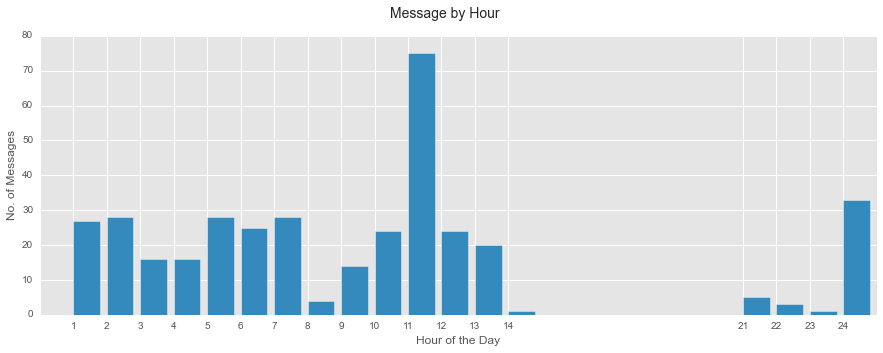

In [18]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,1,1)
ax.bar(data[data.name == name].groupby(data[data.name == name].ts.apply(lambda x: x.hour)).text.size().index+1,
       data[data.name == name].groupby(data[data.name == name].ts.apply(lambda x: x.hour)).text.size())
fig.suptitle("Message by Hour",fontsize= 14)
ax.set_xlabel("Hour of the Day")
ax.set_xticks(data[data.name == name].groupby(data[data.name == name].ts.apply(lambda x: x.hour)).text.size().index+ 1)
ax.set_ylabel("No. of Messages")
#fig.savefig("Aggregated Hours.png")

The below graph shows the messages I used per day

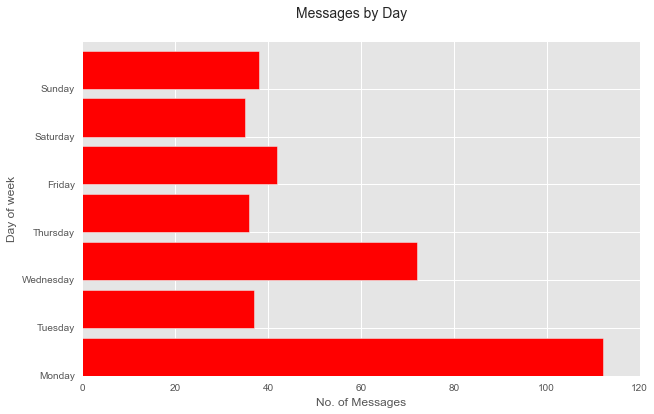

In [19]:
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.barh(data[data.name == name].groupby(data[data.name == name].ts.apply(lambda x: x.dayofweek)).text.size().index +1,
        data[data.name == name].groupby(data[data.name == name].ts.apply(lambda x: x.dayofweek)).text.size(),color='red')
fig.suptitle("Messages by Day",fontsize= 14)
ax.set_ylabel("Day of week")
ax.set_yticklabels(days) #jared.groupby(jared.ts.apply(lambda x: x.dayofweek)).text.size().index+ 1)
ax.set_xlabel("No. of Messages")
#fig.savefig("Aggregated Day of Week.png")

In [79]:
data[data.name == name].groupby(data[data.name == name].ts.apply(lambda x: datetime.datetime.date(x))).text.size()

ts
2016-03-30     4
2016-03-31     3
2016-04-01     2
2016-04-02     3
2016-04-03     6
2016-04-04     8
2016-04-07     1
2016-04-11     5
2016-04-12     3
2016-04-13     2
2016-04-14     2
2016-04-15     3
2016-04-16     1
2016-04-17    13
2016-04-18     5
2016-04-22     6
2016-04-24     3
2016-04-25    15
2016-04-28     3
2016-04-29     5
2016-04-30    18
2016-05-01    13
2016-05-04    27
2016-05-05     5
2016-05-06     3
2016-05-07    10
2016-05-08     3
2016-05-09    79
2016-05-10    34
2016-05-11    39
2016-05-12    22
2016-05-13    23
2016-05-14     2
dtype: int64

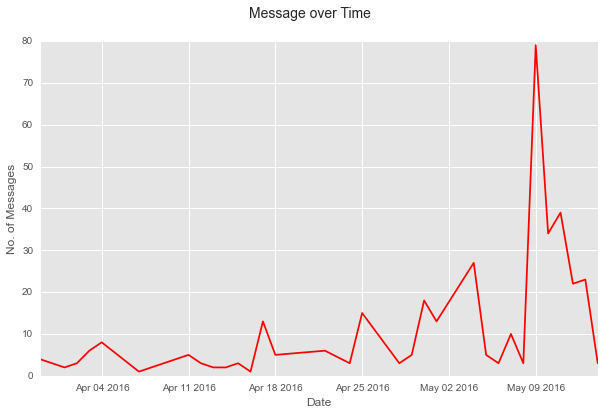

In [20]:
import datetime
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(data[data.name == name].groupby(data[data.name == name].ts.apply(lambda x: datetime.datetime.date(x))).text.size().index,
        data[data.name == name].groupby(data[data.name == name].ts.apply(lambda x: datetime.datetime.date(x))).text.size().values,color='red')
fig.suptitle("Message over Time",fontsize= 14)
ax.set_ylabel("No. of Messages")
#ax.set_yticklabels(days) #jared.groupby(jared.ts.apply(lambda x: x.dayofweek)).text.size().index+ 1)
ax.set_xlabel("Date")
#fig.savefig("Aggregated Day of Week.png")

## Part 6 Sentiment Analysis

Indico, Aylien and Alchemy API's

http://journalofbigdata.springeropen.com/articles/10.1186/s40537-015-0015-2


In [68]:
data2 = pd.read_csv("Final_Merged_Output2.csv")

In [72]:
data2['date'] = pd.to_datetime(data2['date'],unit='s')

In [56]:
data2[data.name == name].groupby(data2[data2.name == name].ts2).clean_text_x.size()

ts2
2016-01-04    2
2016-02-04    3
2016-03-04    6
2016-03-30    4
2016-03-31    3
2016-04-04    8
2016-07-04    1
2016-11-04    4
dtype: int64

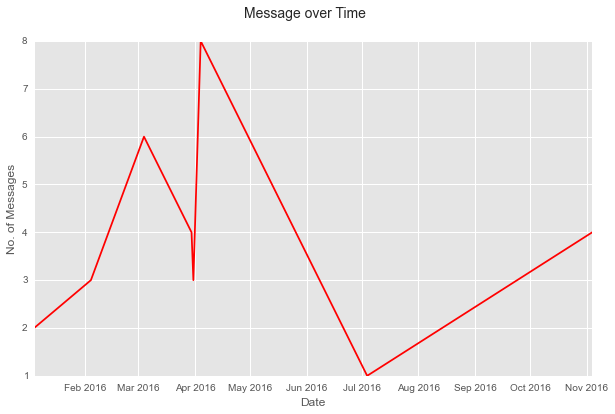

In [74]:
import datetime
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(data2[data.name == name].groupby(data2[data2.name == name].date).clean_text_x.size().index,
        data2[data.name == name].groupby(data2[data2.name == name].date).clean_text_x.size().values,color='red')
fig.suptitle("Message over Time",fontsize= 14)
ax.set_ylabel("No. of Messages")
#ax.set_yticklabels(days) #jared.groupby(jared.ts.apply(lambda x: x.dayofweek)).text.size().index+ 1)
ax.set_xlabel("Date")
#fig.savefig("Aggregated Day of Week.png")

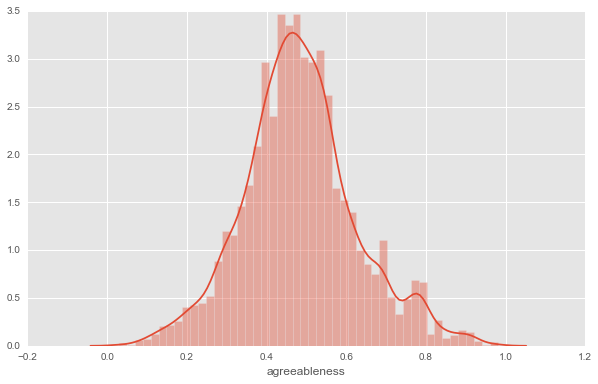

In [44]:
fig, ax = plt.subplots(figsize=(10,6))

sns.distplot(data2.agreeableness)


### Privacy

Privacy
Identifies, contextualises, and reflects on the ethical, privacy, and legal issues relevant to the collection and analysis of personal data of self and others
INTRUSIVE mystery box challenge privacy
Privacy in conversation sharing as a contract between groups
Privacy policies in software
https://slack.com/privacy-policy
https://www.atlassian.com/legal/privacy-policy
https://confluence.atlassian.com/doc/data-collection-policy-659783908.html


## Conclusion

## Reflection

## References

## Appendcies